In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

from tqdm import tqdm

from keras import Sequential
from keras import layers
from keras import callbacks

plt.style.use('ggplot')
sns.set_palette(sns.color_palette('hls', 10))

**In this notebook we will make forecast using weekly data, not monthly data.**
As we have more data, we will use a train-test approach (in R we didn't split the data).
We will se two diffeent approaches: using univariate data with country aggregate and using multivariate.

# Load data

In [2]:
# Load data
data = pd.read_csv('hungary_chickenpox.csv')
# Set correct data type and set new index
data.Date = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.set_index('Date', inplace=True)
display(data.head())

,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
Date,,,,,,,,,,,,,,,,,,,,
2005-01-03,168,79,30,173,169,42,136,120,162,36,130,57,2,178,66,64,11,29,87,68
2005-01-10,157,60,30,92,200,53,51,70,84,28,80,50,29,141,48,29,58,53,68,26
2005-01-17,96,44,31,86,93,30,93,84,191,51,64,46,4,157,33,33,24,18,62,44
2005-01-24,163,49,43,126,46,39,52,114,107,42,63,54,14,107,66,50,25,21,43,31
2005-01-31,122,78,53,87,103,34,95,131,172,40,61,49,11,124,63,56,7,47,85,60


# Univariate

In [3]:
# Create univariate timeseries by using the country total
total_ts = data.sum(axis=1)
total_ts.name = 'weekly_cases'
print(total_ts.head())

Date
2005-01-03    1807
2005-01-10    1407
2005-01-17    1284
2005-01-24    1255
2005-01-31    1478
Name: weekly_cases, dtype: int64


In the following cell we will set some constants to use after in the code.

In [4]:
# Constants
LOOKBACK: int = 52
TRAIN_SIZE: float = 0.8
FORECAST_HORIZON: int = 1
VALIDATION_SPLITS = 4  # 20-80, 40-60, 60-40, 80-20

## Set up data

In [5]:
# Create data for RNN
def create_X_y(tseries: np.ndarray, lookback: int = LOOKBACK, forecast_horizon: int = FORECAST_HORIZON) -> (np.ndarray, np.ndarray):
    """
    Create data to be used in RNN.
    Example:
        let lookback = 2, forecast_horizon = 1 and tseries = [1, 2, 3, 4, 5]. The the output is
        (
        [[[1], [2]]
         [[2], [3]]
         [[3], [4]]]
        ,  
        [3, 4, 5]
        )
    """
    result_x = []
    result_y = []
    for i in range(len(tseries) - lookback - forecast_horizon + 1):
        result_x.append(np.reshape(tseries[i: i + lookback], (lookback, -1)))
        result_y.append(tseries[i + lookback + forecast_horizon - 1])
    return np.array(result_x), np.array(result_y)

In [6]:
X, y = create_X_y(total_ts.values)
print(f'{len(total_ts) = }')
print(f'{X.shape = }\n{y.shape = }')

len(total_ts) = 522
X.shape = (470, 52, 1)
y.shape = (470,)


In [7]:
# Split in train and test
X_train = X[:int(len(X) * TRAIN_SIZE)]
y_train = y[:int(len(y) * TRAIN_SIZE)]

X_test = X[int(len(X) * TRAIN_SIZE):]
y_test = y[int(len(X) * TRAIN_SIZE):]

## Models

In [8]:
# RNN
def create_RNN_model(hidden_units: int,
                     lookback: int = LOOKBACK,
                     optimizer: str = 'adam',
                     loss: str = "mean_squared_error",
                     hidden_activation: str = 'relu',
                     n_features: int = 1) -> Sequential:
    model = Sequential()
    model.add(
        layers.InputLayer(shape=(lookback, n_features), return_sequences=True)
    )
    model.add(
        layers.SimpleRNN(units=hidden_units, activation=hidden_activation, return_sequences=True)
    )
    model.add(
        layers.Dropout(0.2)
    )
    model.add(
        layers.SimpleRNN(units=hidden_units, activation=hidden_activation, return_sequences=False)
    )
    model.add(
        layers.Dense(units=n_features, activation="relu")  # Activation = relu because prediction must be always >= 0
    )
    # Compile model
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [9]:
# LSTM
def create_LSTM_model(hidden_units: int,
                      lookback: int = LOOKBACK,
                      optimizer: str = 'adam',
                      loss: str = "mean_squared_error",
                      hidden_activation: str = 'relu',
                      n_features: int = 1) -> Sequential:
    model = Sequential()
    model.add(
        layers.InputLayer(shape=(lookback, n_features), return_sequences=True)
    )
    model.add(
        layers.LSTM(units=hidden_units, activation = hidden_activation, return_sequences = True)
    )
    model.add(
        layers.Dropout(0.2)
    )
    model.add(
        layers.LSTM(units=hidden_units, activation = hidden_activation, return_sequences = False)
    )
    model.add(
        layers.Dense(units=n_features, activation="relu") # Activation = relu because prediction must be always >= 0
    )
    # Compile model
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [10]:
# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    start_from_epoch=10
)

In [11]:
def create_splits(x: np.ndarray, y:np.ndarray | None = None, n_splits: int = VALIDATION_SPLITS):
    """
    Creates splits for cross-validation
    """
    split_index = len(x) // (n_splits + 1)
    split_x = []
    for i in range(1, n_splits + 1):
        t = split_index * i
        split_x.append((x[:t], x[t:]))
    if y is not None:
        assert len(x) == len(y)
        split_y = []
        for i in range(1, n_splits + 1):
            t = split_index * i
            split_y.append((y[:t], y[t:]))
        return split_x, split_y
    return split_x

In [12]:
# Split train data to create 4 validation sets, maintaining the temporal order (Validation sets decrease in size from 80% down to 20%). 
x_split, y_split = create_splits(X_train, y_train)

print("X splits:")
for s in range(VALIDATION_SPLITS):
    print(f"Split {s}: Train shape = {x_split[s][0].shape}\tValidation shape = {x_split[s][1].shape}")
print("y splits:")
for s in range(VALIDATION_SPLITS):
    print(f"Split {s}: Train shape = {y_split[s][0].shape}\tValidation shape = {y_split[s][1].shape}")

X splits:
Split 0: Train shape = (75, 52, 1)	Validation shape = (301, 52, 1)
Split 1: Train shape = (150, 52, 1)	Validation shape = (226, 52, 1)
Split 2: Train shape = (225, 52, 1)	Validation shape = (151, 52, 1)
Split 3: Train shape = (300, 52, 1)	Validation shape = (76, 52, 1)
y splits:
Split 0: Train shape = (75,)	Validation shape = (301,)
Split 1: Train shape = (150,)	Validation shape = (226,)
Split 2: Train shape = (225,)	Validation shape = (151,)
Split 3: Train shape = (300,)	Validation shape = (76,)


Some functions to select best hyperparameters

In [13]:
def train_validate_split(model: Sequential, train_x, train_y, val_x, val_y, callbacks, epochs: int, batch_size: int | None) -> float:
    # Fit model
    model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=0)
    return model.evaluate(val_x, val_y, verbose=0)

In [14]:
def train_validate(model: Sequential, split_x, split_y, callbacks, epochs: int, batch_size: int | None) -> list[float]:
    splits_loss = []
    for s in range(VALIDATION_SPLITS):
        # Scale data
        divisor = split_x[s][0].max()
        train_x = split_x[s][0] / divisor
        train_y = split_y[s][0] / divisor
        val_x = split_x[s][1] / divisor
        val_y = split_y[s][1] / divisor
        # Compute loss for split s
        s_loss = train_validate_split(model, train_x, train_y, val_x, val_y, callbacks, epochs, batch_size)
        splits_loss.append(s_loss)
    return splits_loss

## RNN Training

In [15]:
max_units = 100
max_epochs = 100
batch_size = 16

RNN_results = dict()
for n_units in tqdm(range(1, max_units + 1)):
    model = create_RNN_model(hidden_units=n_units)
    #print(f'n_units = {n_units}...', end='\t')
    splits_loss = train_validate(model, x_split, y_split, callbacks=[early_stopping], epochs=max_epochs, batch_size=batch_size)
    RNN_results[n_units] = splits_loss
    #print(f'Results = {np.round(splits_loss, 5)}\tAverage loss = {round(np.mean(splits_loss), 5)}')

RNN_results = pd.DataFrame(RNN_results, index=[f'split_{i}' for i in range(1, VALIDATION_SPLITS + 1)]).T
RNN_results.index.name = 'n_units'
RNN_results['average'] = RNN_results.mean(axis=1)
display(RNN_results)

100%|██████████| 100/100 [21:52<00:00, 13.13s/it]


,split_1,split_2,split_3,split_4,average
n_units,,,,,
1,0.148323,0.114019,0.103638,0.088247,0.113557
2,0.148323,0.114019,0.031293,0.025638,0.079818
3,0.068131,0.046013,0.035415,0.008205,0.039441
4,0.060716,0.038470,0.026783,0.015874,0.035461
5,0.148323,0.114019,0.103638,0.088247,0.113557
...,...,...,...,...,...
96,0.148323,0.114019,0.006678,0.006708,0.068932
97,0.012570,0.007134,0.006133,0.006127,0.007991
98,0.012157,0.007284,0.006345,0.007492,0.008319


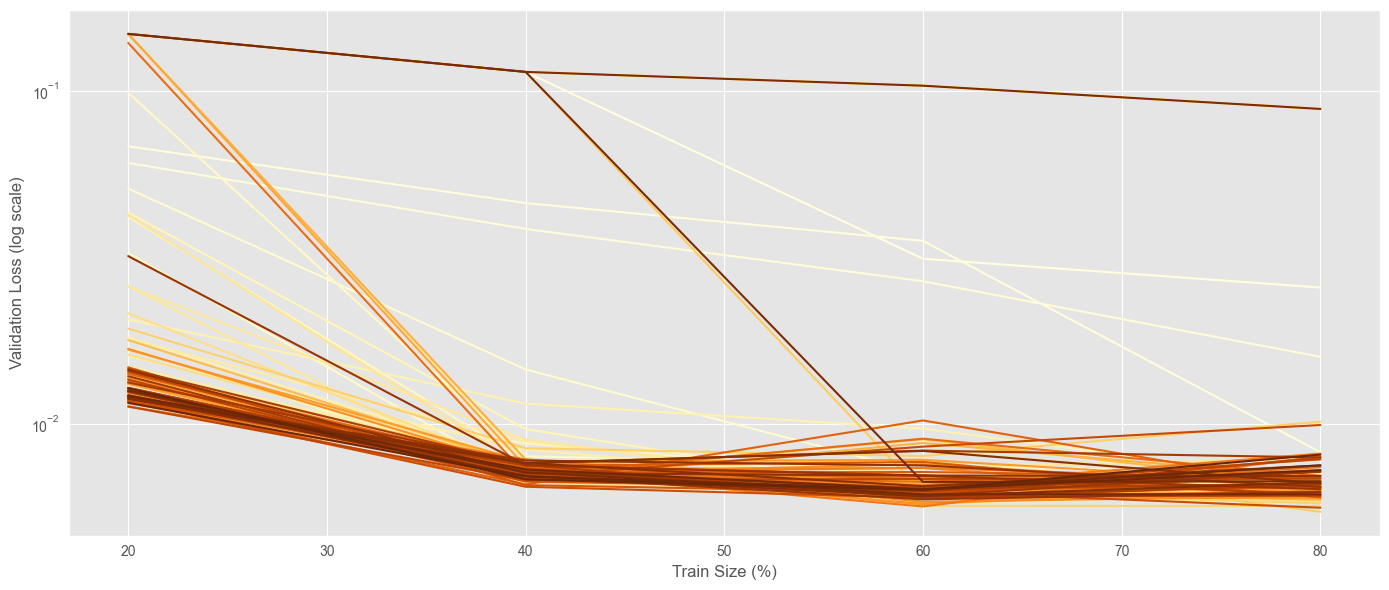

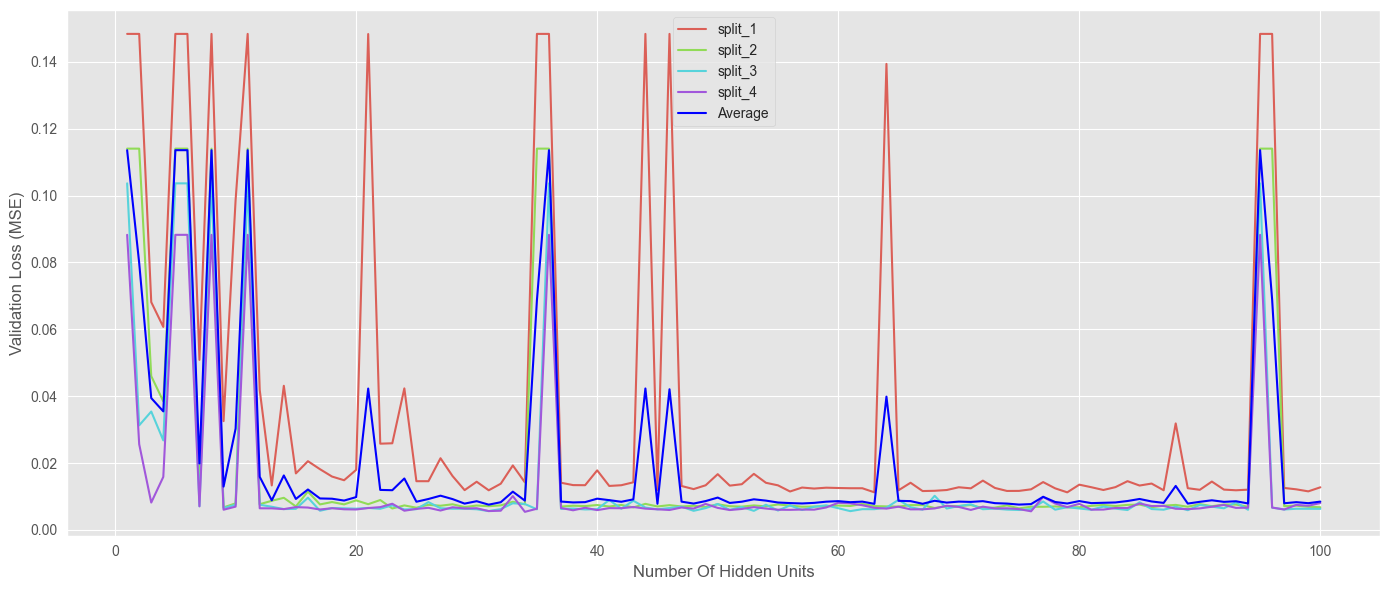

In [16]:
df = RNN_results

sns.set_palette(sns.color_palette("YlOrBr", max_units, as_cmap=False))
fig1, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
for u in df.index:
    ax.plot((100/(VALIDATION_SPLITS + 1)) * np.arange(1, VALIDATION_SPLITS + 1), df.loc[u][:4], label=f'n_units = {u}')
ax.set_xlabel('Train Size (%)')
ax.set_ylabel('Validation Loss (log scale)')
ax.set_yscale('log')
#ax.legend(fontsize='xx-small')
plt.show()

sns.set_palette(sns.color_palette('hls', 4))

fig3, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
for col in df.columns[:VALIDATION_SPLITS]:
    ax.plot(df.index, df[col], label=f'{col}')
ax.plot(df.index, df.average, label='Average', color='blue')
ax.legend()
ax.set_xlabel('Number Of Hidden Units')
ax.set_ylabel('Validation Loss (MSE)')

plt.show()

## LSTM Training

In [17]:
max_units = 100
max_epochs = 100
batch_size = 16

LSTM_results = dict()
for n_units in tqdm(range(1, max_units + 1)):
    model = create_LSTM_model(hidden_units=n_units)
    #print(f'n_units = {n_units}...', end='\t')
    splits_loss = train_validate(model, x_split, y_split, callbacks=[early_stopping], epochs=max_epochs, batch_size=batch_size)
    LSTM_results[n_units] = splits_loss
    #print(f'Results = {np.round(splits_loss, 5)}\tAverage loss = {round(np.mean(splits_loss), 5)}')
    
LSTM_results = pd.DataFrame(LSTM_results, index=[f'split_{i}' for i in range(1, VALIDATION_SPLITS + 1)]).T
LSTM_results.index.name = 'n_units'
LSTM_results['average'] = LSTM_results.mean(axis=1)
display(LSTM_results)

100%|██████████| 100/100 [35:39<00:00, 21.39s/it]


,split_1,split_2,split_3,split_4,average
n_units,,,,,
1,0.148323,0.114019,0.103638,0.088247,0.113557
2,0.148323,0.114019,0.103638,0.088247,0.113557
3,0.091476,0.029251,0.010987,0.009270,0.035246
4,0.148323,0.114019,0.103638,0.088247,0.113557
5,0.057260,0.024006,0.014113,0.012832,0.027053
...,...,...,...,...,...
96,0.024877,0.006751,0.007545,0.007931,0.011776
97,0.026467,0.012095,0.007356,0.007351,0.013317
98,0.029037,0.006942,0.006460,0.006610,0.012262


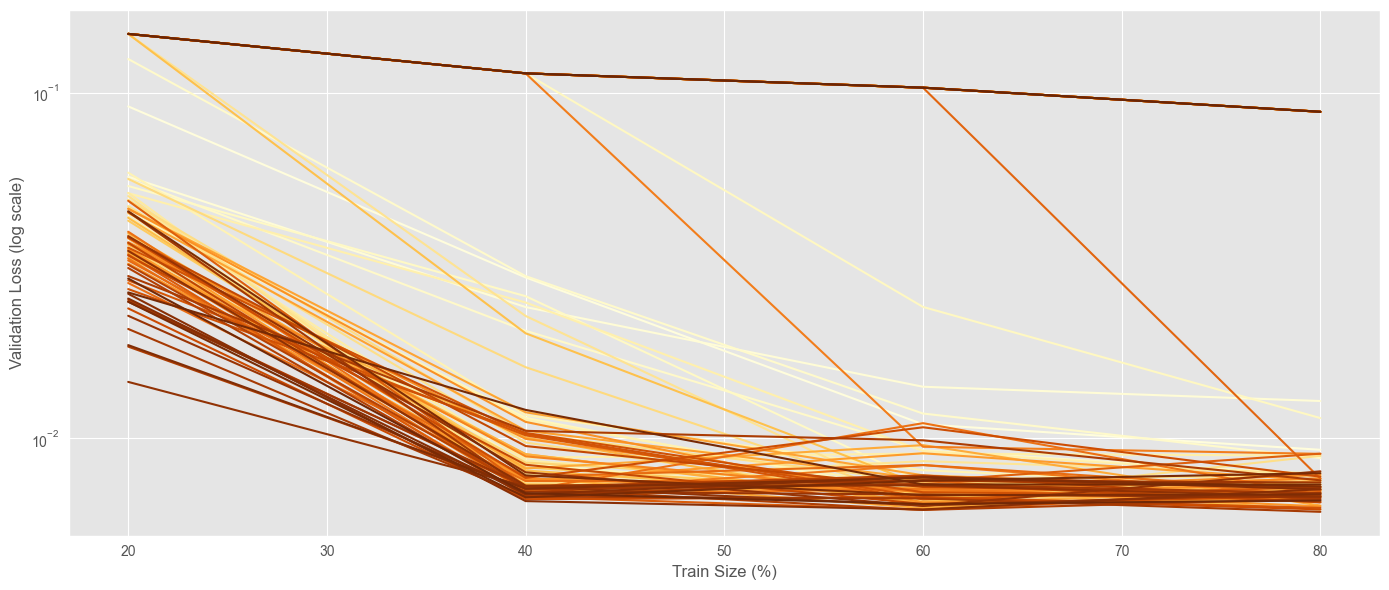

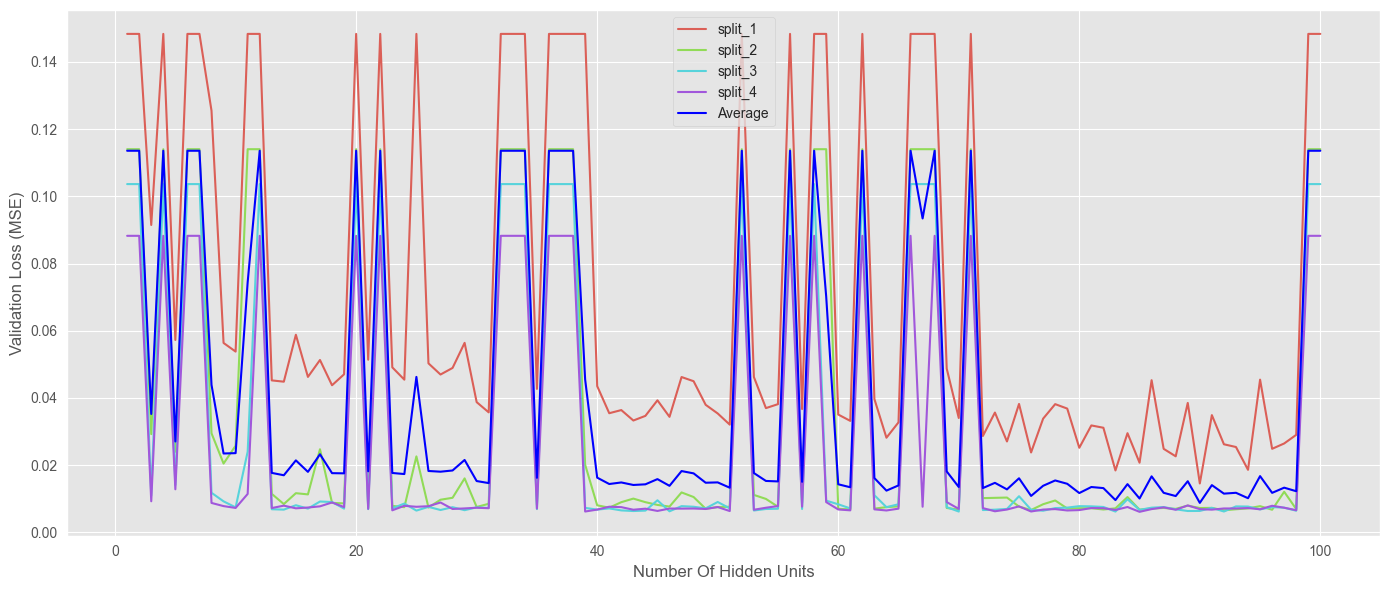

In [18]:
df = LSTM_results

sns.set_palette(sns.color_palette("YlOrBr", max_units, as_cmap=False))
fig1, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
for u in df.index:
    ax.plot((100/(VALIDATION_SPLITS + 1)) * np.arange(1, VALIDATION_SPLITS + 1), df.loc[u][:4], label=f'n_units = {u}')
ax.set_xlabel('Train Size (%)')
ax.set_ylabel('Validation Loss (log scale)')
ax.set_yscale('log')
plt.show()

sns.set_palette(sns.color_palette('hls', 4))

fig3, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
for col in df.columns[:VALIDATION_SPLITS]:
    ax.plot(df.index, df[col], label=f'{col}')
ax.plot(df.index, df.average, label='Average', color='blue')
ax.legend()
ax.set_xlabel('Number Of Hidden Units')
ax.set_ylabel('Validation Loss (MSE)')

plt.show()

After the search for the optimal number of hidden units, we will use 40 hidden units for RNN and 50 hidden units for LSTM.

In [19]:
# Scale data
s = VALIDATION_SPLITS - 1
divisor = x_split[s][0].max()

X_train_scaled = x_split[s][0] / divisor
y_train_scaled = y_split[s][0] / divisor

X_val_scaled = x_split[s][1] / divisor
y_val_scaled = y_split[s][1] / divisor

X_test_scaled = X_test / divisor
y_test_scaled = y_test / divisor

In [20]:
# Create models
RNN_univariate = create_RNN_model(hidden_units=40)
LSTM_univariate = create_LSTM_model(hidden_units=50)
# Train models
print('Training RNN model')
history_rnn_univariate = RNN_univariate.fit(X_train_scaled, y_train_scaled,
                                            validation_data=(X_val_scaled, y_val_scaled), callbacks=[early_stopping], batch_size=16, epochs=100)
print('Training LSTM model')
history_lstm_univariate = LSTM_univariate.fit(X_train_scaled, y_train_scaled,
                                              validation_data=(X_val_scaled, y_val_scaled), callbacks=[early_stopping], batch_size=16, epochs=100)

Training RNN model
Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.1038 - val_loss: 0.0142
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0202 - val_loss: 0.0068
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0112 - val_loss: 0.0065
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0116 - val_loss: 0.0066
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0119 - val_loss: 0.0063
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0127 - val_loss: 0.0063
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0122 - val_loss: 0.0063
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0099 - val_loss: 0.0063
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0092 - val_loss: 0.0076
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0112 - val_loss: 0.0061
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0116 - val_loss: 0.0061
Epoch 12/100
19/19 ━━━━━━━━━━━━━━

In [21]:
# Predictions
prediction_rnn_univariate = RNN_univariate.predict(X_test_scaled) * divisor
prediction_lstm_univariate = LSTM_univariate.predict(X_test_scaled) * divisor

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


## Visualize Forecast

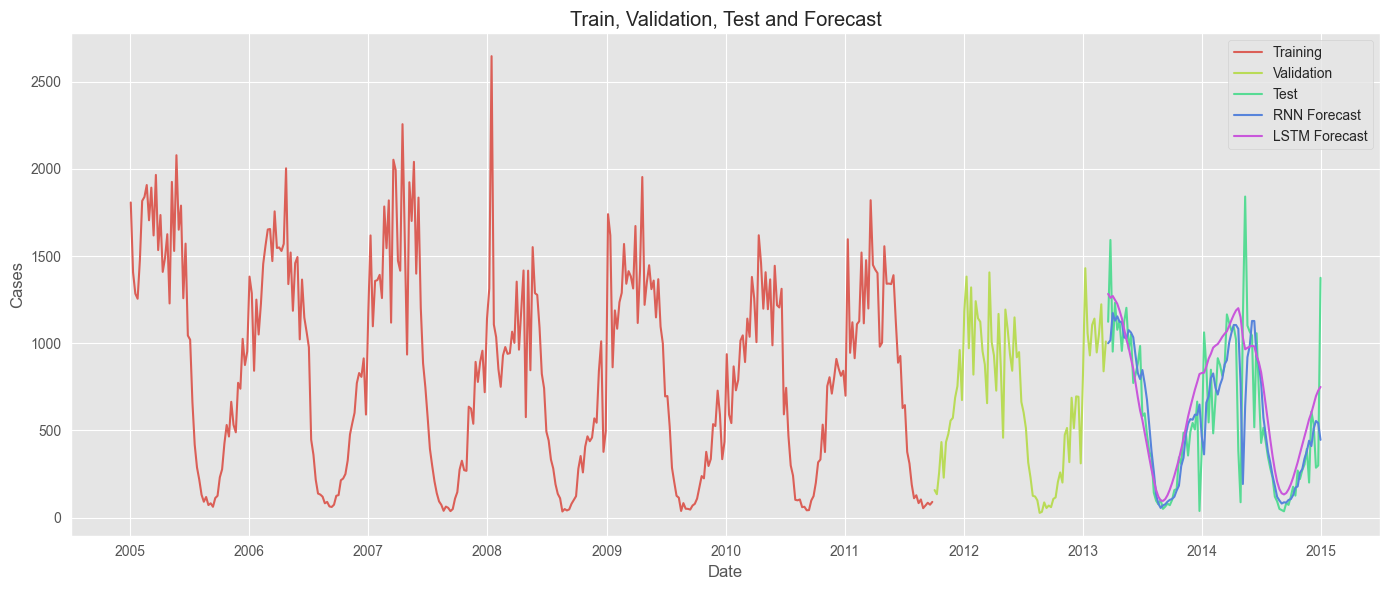

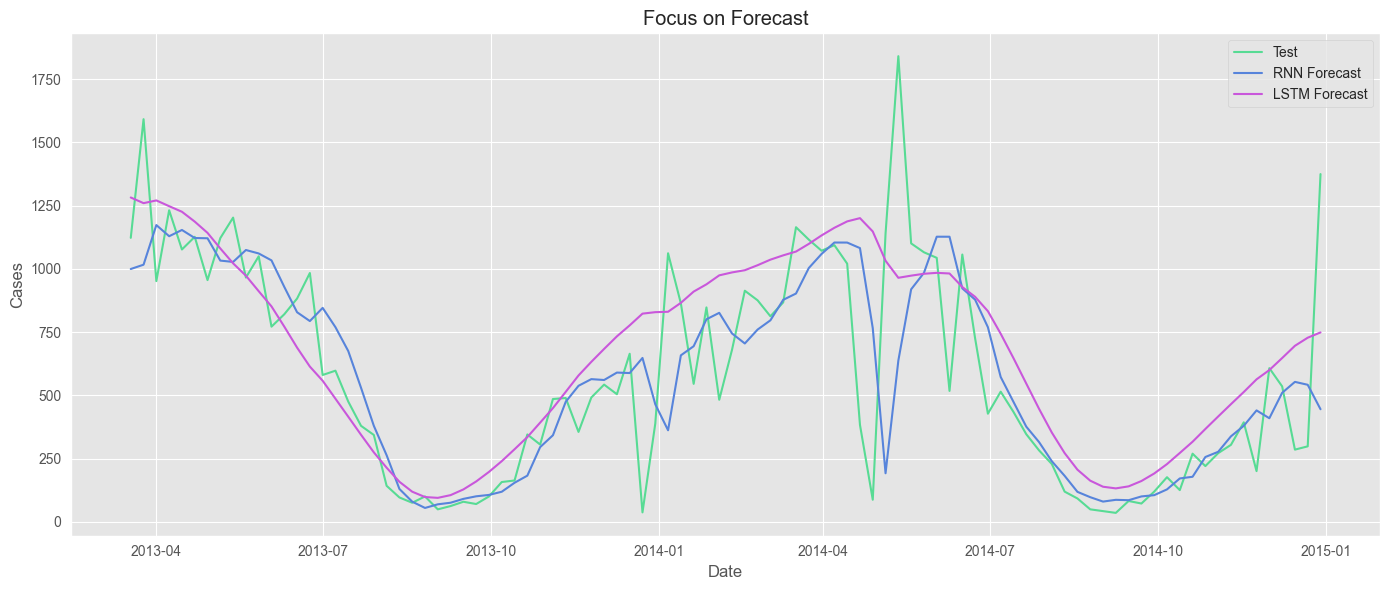

In [22]:
sns.set_palette(sns.color_palette('hls', 5))

h = len(y_train_scaled) + LOOKBACK
k = len(y_train_scaled) + len(y_val_scaled) + LOOKBACK

fig5, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
ax.plot(total_ts[:h], label='Training')
ax.plot(total_ts[h:k], label='Validation')
ax.plot(total_ts[k:], label='Test')
ax.plot(total_ts.index[k:], prediction_rnn_univariate, label='RNN Forecast')
ax.plot(total_ts.index[k:], prediction_lstm_univariate, label='LSTM Forecast')
ax.set_title('Train, Validation, Test and Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
ax.legend()
plt.show()

sns.set_palette(sns.color_palette('hls', 5)[-3:])
fig6, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
ax.plot(total_ts[k:], label='Test')
ax.plot(total_ts.index[k:], prediction_rnn_univariate, label='RNN Forecast')
ax.plot(total_ts.index[k:], prediction_lstm_univariate, label='LSTM Forecast')
ax.set_title('Focus on Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
ax.legend()
plt.show()

In [23]:
# Compute metrcs
mse = (mean_squared_error(y_test, prediction_rnn_univariate), mean_squared_error(y_test, prediction_lstm_univariate))
rmse = (root_mean_squared_error(y_test, prediction_rnn_univariate), root_mean_squared_error(y_test, prediction_lstm_univariate))
mae = (mean_absolute_error(y_test, prediction_rnn_univariate), mean_absolute_error(y_test, prediction_lstm_univariate))
mape = (mean_absolute_percentage_error(y_test, prediction_rnn_univariate), mean_absolute_percentage_error(y_test, prediction_lstm_univariate))

df_metrics_univariate = pd.DataFrame([mse, rmse, mae, mape], columns=['RNN', 'LSTM'], index=['MSE', 'RMSE', 'MAE', 'MAPE'])

In [24]:
display(df_metrics_univariate)

,RNN,LSTM
MSE,75422.578241,69743.724458
RMSE,274.631714,264.090372
MAE,159.003447,178.962861
MAPE,0.552360,0.839225


# Multivariate
We will use 20 features instead of 1.

## Set up data

In [25]:
X, y = create_X_y(data.values)
print(f'{len(data) = }')
print(f'{X.shape = }\n{y.shape = }')

len(data) = 522
X.shape = (470, 52, 20)
y.shape = (470, 20)


In [26]:
X_train = X[:int(len(X) * TRAIN_SIZE)]
y_train = y[:int(len(y) * TRAIN_SIZE)]

X_test = X[int(len(X) * TRAIN_SIZE):]
y_test = y[int(len(X) * TRAIN_SIZE):]

## Models

In [27]:
x_split, y_split = create_splits(X_train, y_train)

print("X splits:")
for s in range(VALIDATION_SPLITS):
    print(f"Split {s}: Train shape = {x_split[s][0].shape}\tValidation shape = {x_split[s][1].shape}")
print("y splits:")
for s in range(VALIDATION_SPLITS):
    print(f"Split {s}: Train shape = {y_split[s][0].shape}\tValidation shape = {y_split[s][1].shape}")

X splits:
Split 0: Train shape = (75, 52, 20)	Validation shape = (301, 52, 20)
Split 1: Train shape = (150, 52, 20)	Validation shape = (226, 52, 20)
Split 2: Train shape = (225, 52, 20)	Validation shape = (151, 52, 20)
Split 3: Train shape = (300, 52, 20)	Validation shape = (76, 52, 20)
y splits:
Split 0: Train shape = (75, 20)	Validation shape = (301, 20)
Split 1: Train shape = (150, 20)	Validation shape = (226, 20)
Split 2: Train shape = (225, 20)	Validation shape = (151, 20)
Split 3: Train shape = (300, 20)	Validation shape = (76, 20)


## RNN Training

In [28]:
max_units = 100
max_epochs = 100
batch_size = 16
n_features = 20

RNN_results = dict()
for n_units in tqdm(range(1, max_units + 1)):
    model = create_RNN_model(hidden_units=n_units, n_features=n_features)
    #print(f'n_units = {n_units}...', end='\t')
    splits_loss = train_validate(model, x_split, y_split, callbacks=[early_stopping], epochs=max_epochs, batch_size=batch_size)
    RNN_results[n_units] = splits_loss
    #print(f'Results = {np.round(splits_loss, 5)}\tAverage loss = {round(np.mean(splits_loss), 5)}')

RNN_results = pd.DataFrame(RNN_results, index=[f'split_{i}' for i in range(1, VALIDATION_SPLITS + 1)]).T
RNN_results.index.name = 'n_units'
RNN_results['average'] = RNN_results.mean(axis=1)
display(RNN_results)

100%|██████████| 100/100 [22:52<00:00, 13.73s/it]


,split_1,split_2,split_3,split_4,average
n_units,,,,,
1,0.020471,0.014012,0.013234,0.011896,0.014903
2,0.016037,0.008547,0.007431,0.006521,0.009634
3,0.016792,0.009528,0.008766,0.007562,0.010662
4,0.013667,0.006231,0.004036,0.003684,0.006905
5,0.015399,0.007310,0.006621,0.005327,0.008664
...,...,...,...,...,...
96,0.007527,0.004663,0.003818,0.003566,0.004894
97,0.006841,0.004207,0.003844,0.003613,0.004626
98,0.006325,0.004157,0.003953,0.003527,0.004491


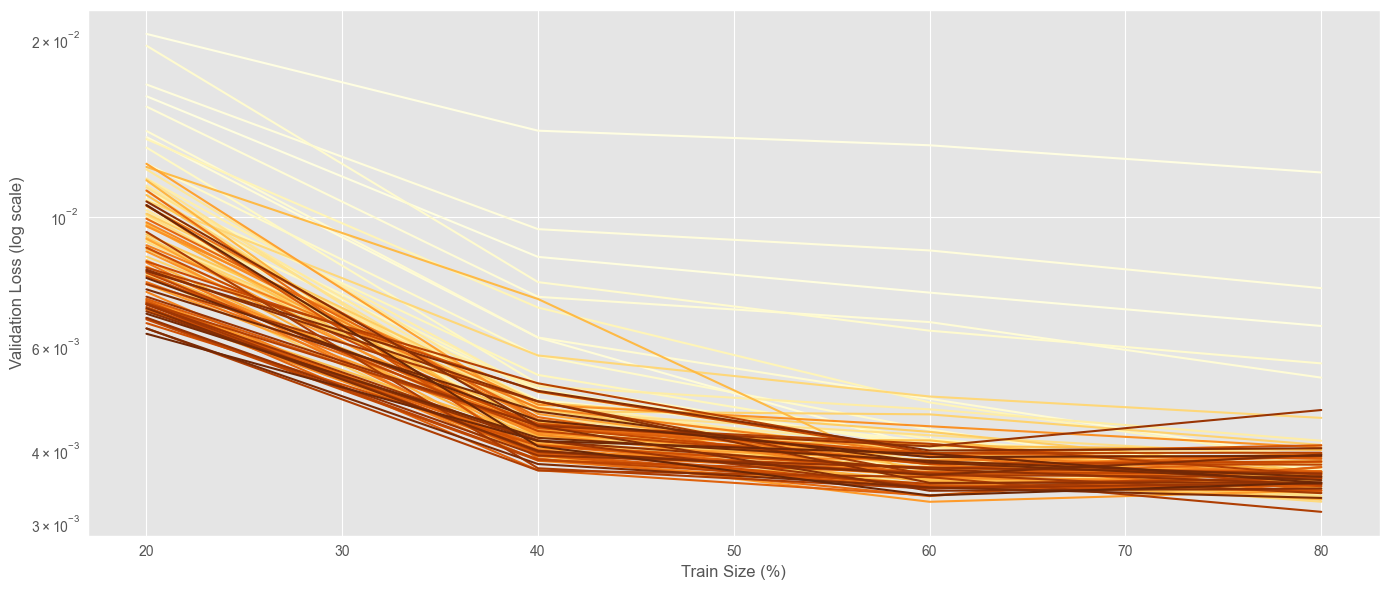

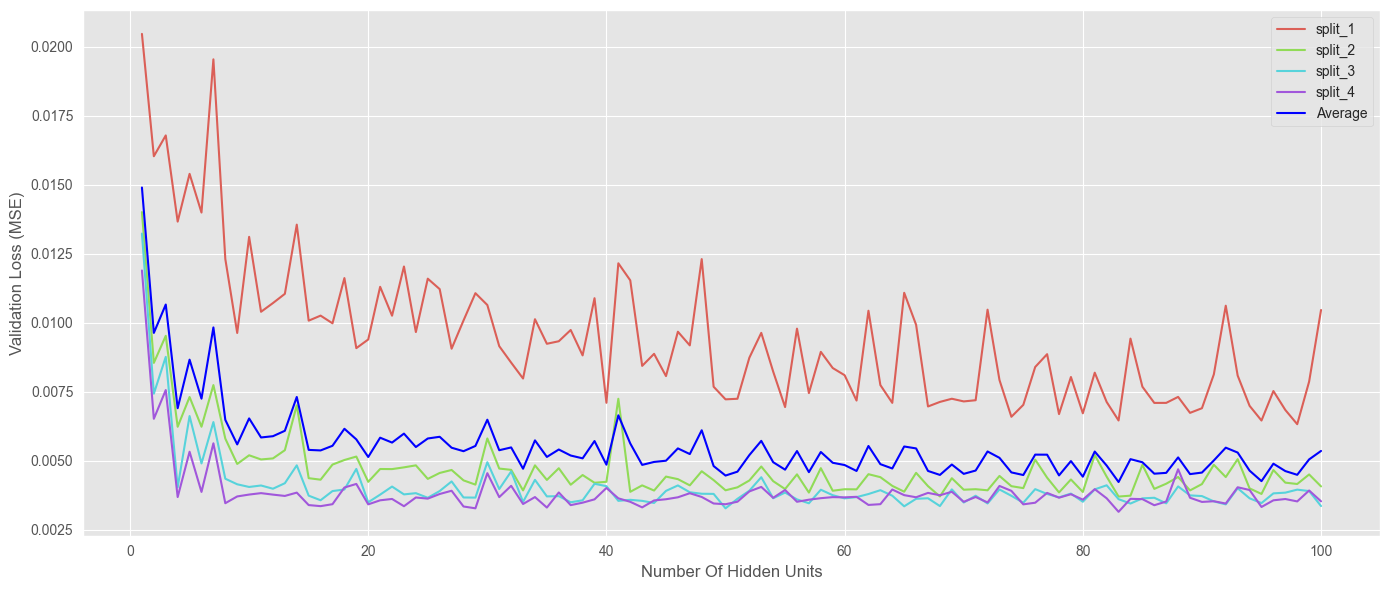

In [29]:
df = RNN_results

sns.set_palette(sns.color_palette("YlOrBr", max_units, as_cmap=False))
fig1, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
for u in df.index:
    ax.plot((100/(VALIDATION_SPLITS + 1)) * np.arange(1, VALIDATION_SPLITS + 1), df.loc[u][:4], label=f'n_units = {u}')
ax.set_xlabel('Train Size (%)')
ax.set_ylabel('Validation Loss (log scale)')
ax.set_yscale('log')
plt.show()

sns.set_palette(sns.color_palette('hls', 4))

fig3, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
for col in df.columns[:VALIDATION_SPLITS]:
    ax.plot(df.index, df[col], label=f'{col}')
ax.plot(df.index, df.average, label='Average', color='blue')
ax.legend()
ax.set_xlabel('Number Of Hidden Units')
ax.set_ylabel('Validation Loss (MSE)')

plt.show()

## LSTM Training

In [30]:
LSTM_results = dict()
for n_units in tqdm(range(1, max_units + 1)):
    model = create_LSTM_model(hidden_units=n_units, n_features=20)
    #print(f'n_units = {n_units}...', end='\t')
    splits_loss = train_validate(model, x_split, y_split, callbacks=[early_stopping], epochs=max_epochs, batch_size=batch_size)
    LSTM_results[n_units] = splits_loss
    #print(f'Results = {np.round(splits_loss, 5)}\tAverage loss = {round(np.mean(splits_loss), 5)}')
    
LSTM_results = pd.DataFrame(LSTM_results, index=[f'split_{i}' for i in range(1, VALIDATION_SPLITS + 1)]).T
LSTM_results.index.name = 'n_units'
LSTM_results['average'] = LSTM_results.mean(axis=1)
display(LSTM_results)

100%|██████████| 100/100 [37:13<00:00, 22.33s/it]


,split_1,split_2,split_3,split_4,average
n_units,,,,,
1,0.016255,0.010691,0.009982,0.008630,0.011390
2,0.014171,0.008089,0.007358,0.006973,0.009148
3,0.017644,0.010255,0.009462,0.008661,0.011505
4,0.015008,0.007852,0.006867,0.006519,0.009062
5,0.013671,0.006355,0.005353,0.004307,0.007422
...,...,...,...,...,...
96,0.008900,0.004244,0.003483,0.003559,0.005046
97,0.007589,0.004323,0.003521,0.003541,0.004743
98,0.009131,0.004106,0.003566,0.003470,0.005068


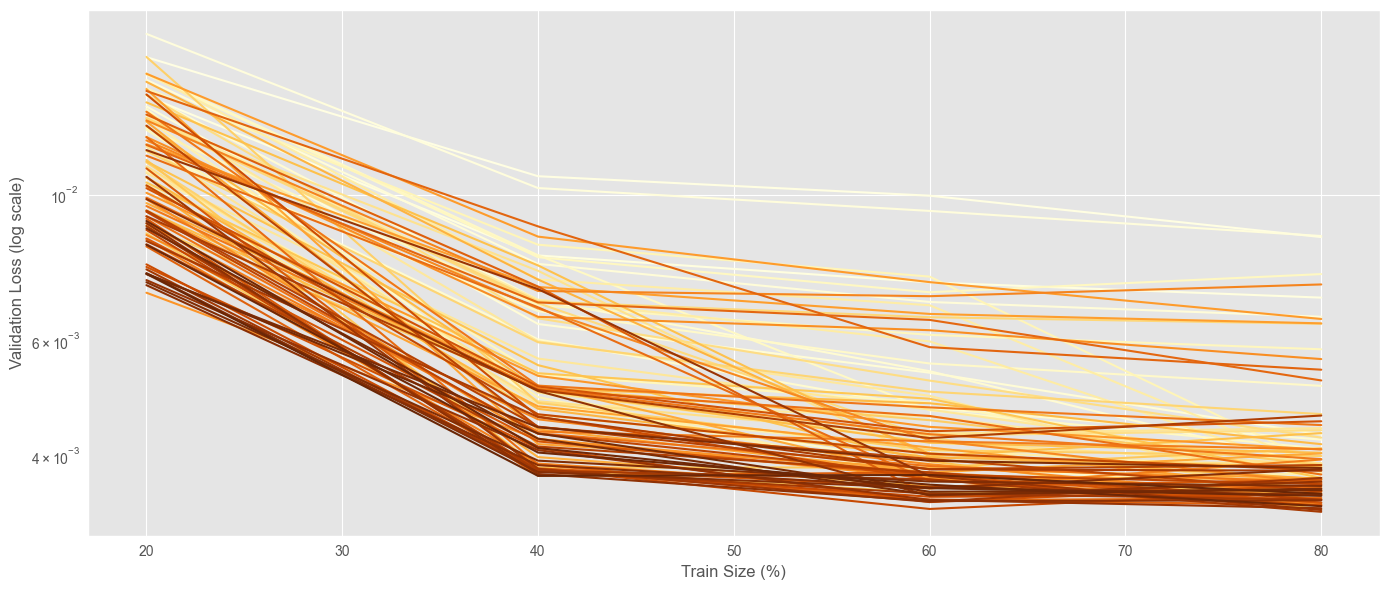

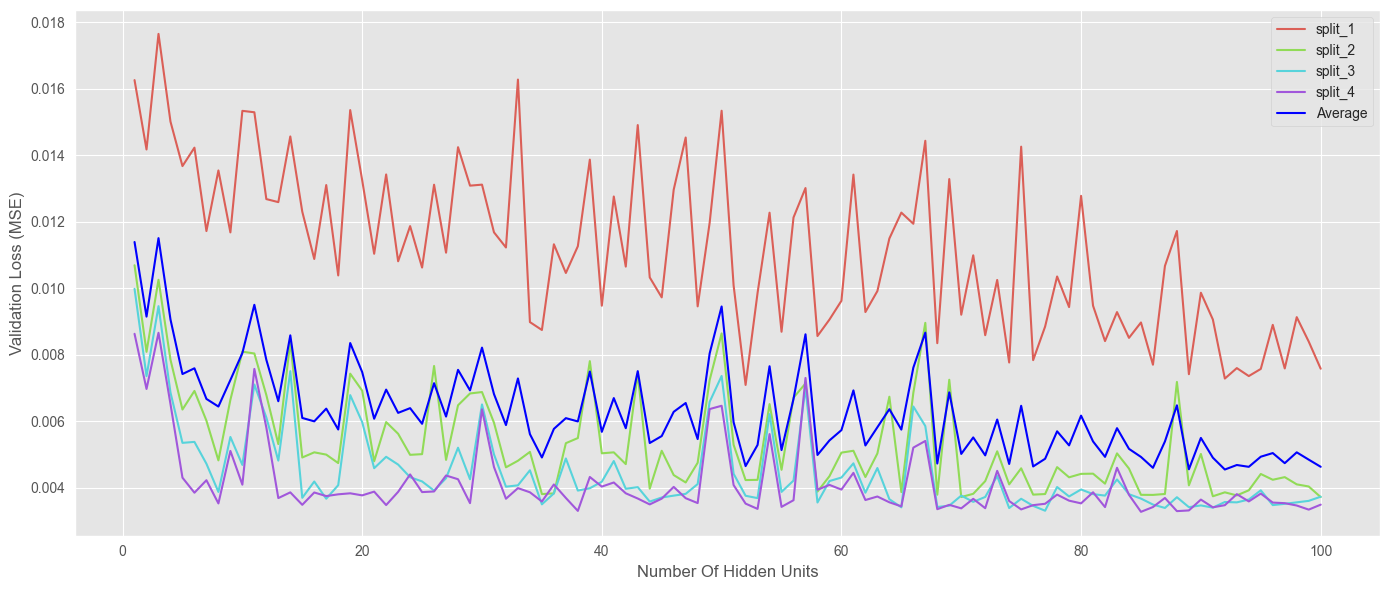

In [31]:
df = LSTM_results

sns.set_palette(sns.color_palette("YlOrBr", max_units, as_cmap=False))
fig1, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
for u in df.index:
    ax.plot((100/(VALIDATION_SPLITS + 1)) * np.arange(1, VALIDATION_SPLITS + 1), df.loc[u][:4], label=f'n_units = {u}')
ax.set_xlabel('Train Size (%)')
ax.set_ylabel('Validation Loss (log scale)')
ax.set_yscale('log')
plt.show()

sns.set_palette(sns.color_palette('hls', 4))

fig3, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
for col in df.columns[:VALIDATION_SPLITS]:
    ax.plot(df.index, df[col], label=f'{col}')
ax.plot(df.index, df.average, label='Average', color='blue')
ax.legend()
ax.set_xlabel('Number Of Hidden Units')
ax.set_ylabel('Validation Loss (MSE)')

plt.show()

After the search for the optimal number of hidden units, we will use 60 hidden units for RNN and 100 hidden units for LSTM.

In [39]:
# Scale data
s = VALIDATION_SPLITS - 1
divisor = x_split[s][0].max()

X_train_scaled = x_split[s][0] / divisor
y_train_scaled = y_split[s][0] / divisor

X_val_scaled = x_split[s][1] / divisor
y_val_scaled = y_split[s][1] / divisor

X_test_scaled = X_test / divisor
y_test_scaled = y_test / divisor

In [40]:
# Create models
RNN_multivariate = create_RNN_model(hidden_units=40, n_features=n_features)
LSTM_multivariate = create_LSTM_model(hidden_units=100, n_features=n_features)
# Train models
print('Training RNN model')
history_rnn_multivariate = RNN_multivariate.fit(X_train_scaled, y_train_scaled,
                                                validation_data=(X_val_scaled, y_val_scaled), callbacks=[early_stopping], batch_size=16, epochs=100)
print('Training LSTM model')
history_lstm_multivariate = LSTM_multivariate.fit(X_train_scaled, y_train_scaled,
                                                  validation_data=(X_val_scaled, y_val_scaled), callbacks=[early_stopping], batch_size=16, epochs=100)

Training RNN model
Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0123 - val_loss: 0.0053
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0074 - val_loss: 0.0045
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060 - val_loss: 0.0042
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 12/100
19/19 ━━━━━━━━━━━━━━

In [41]:
# Predictions
prediction_rnn_multivariate= RNN_multivariate.predict(X_test_scaled) * divisor
prediction_lstm_multivariate = LSTM_multivariate.predict(X_test_scaled) * divisor

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


In [42]:
df_y_test = pd.DataFrame(y_test, columns=data.columns, index=data.index[-len(y_test):])
df_pred_rnn = pd.DataFrame(prediction_rnn_multivariate, columns=data.columns, index=data.index[-len(y_test):])
df_pred_lstm = pd.DataFrame(prediction_lstm_multivariate, columns=data.columns, index=data.index[-len(y_test):])

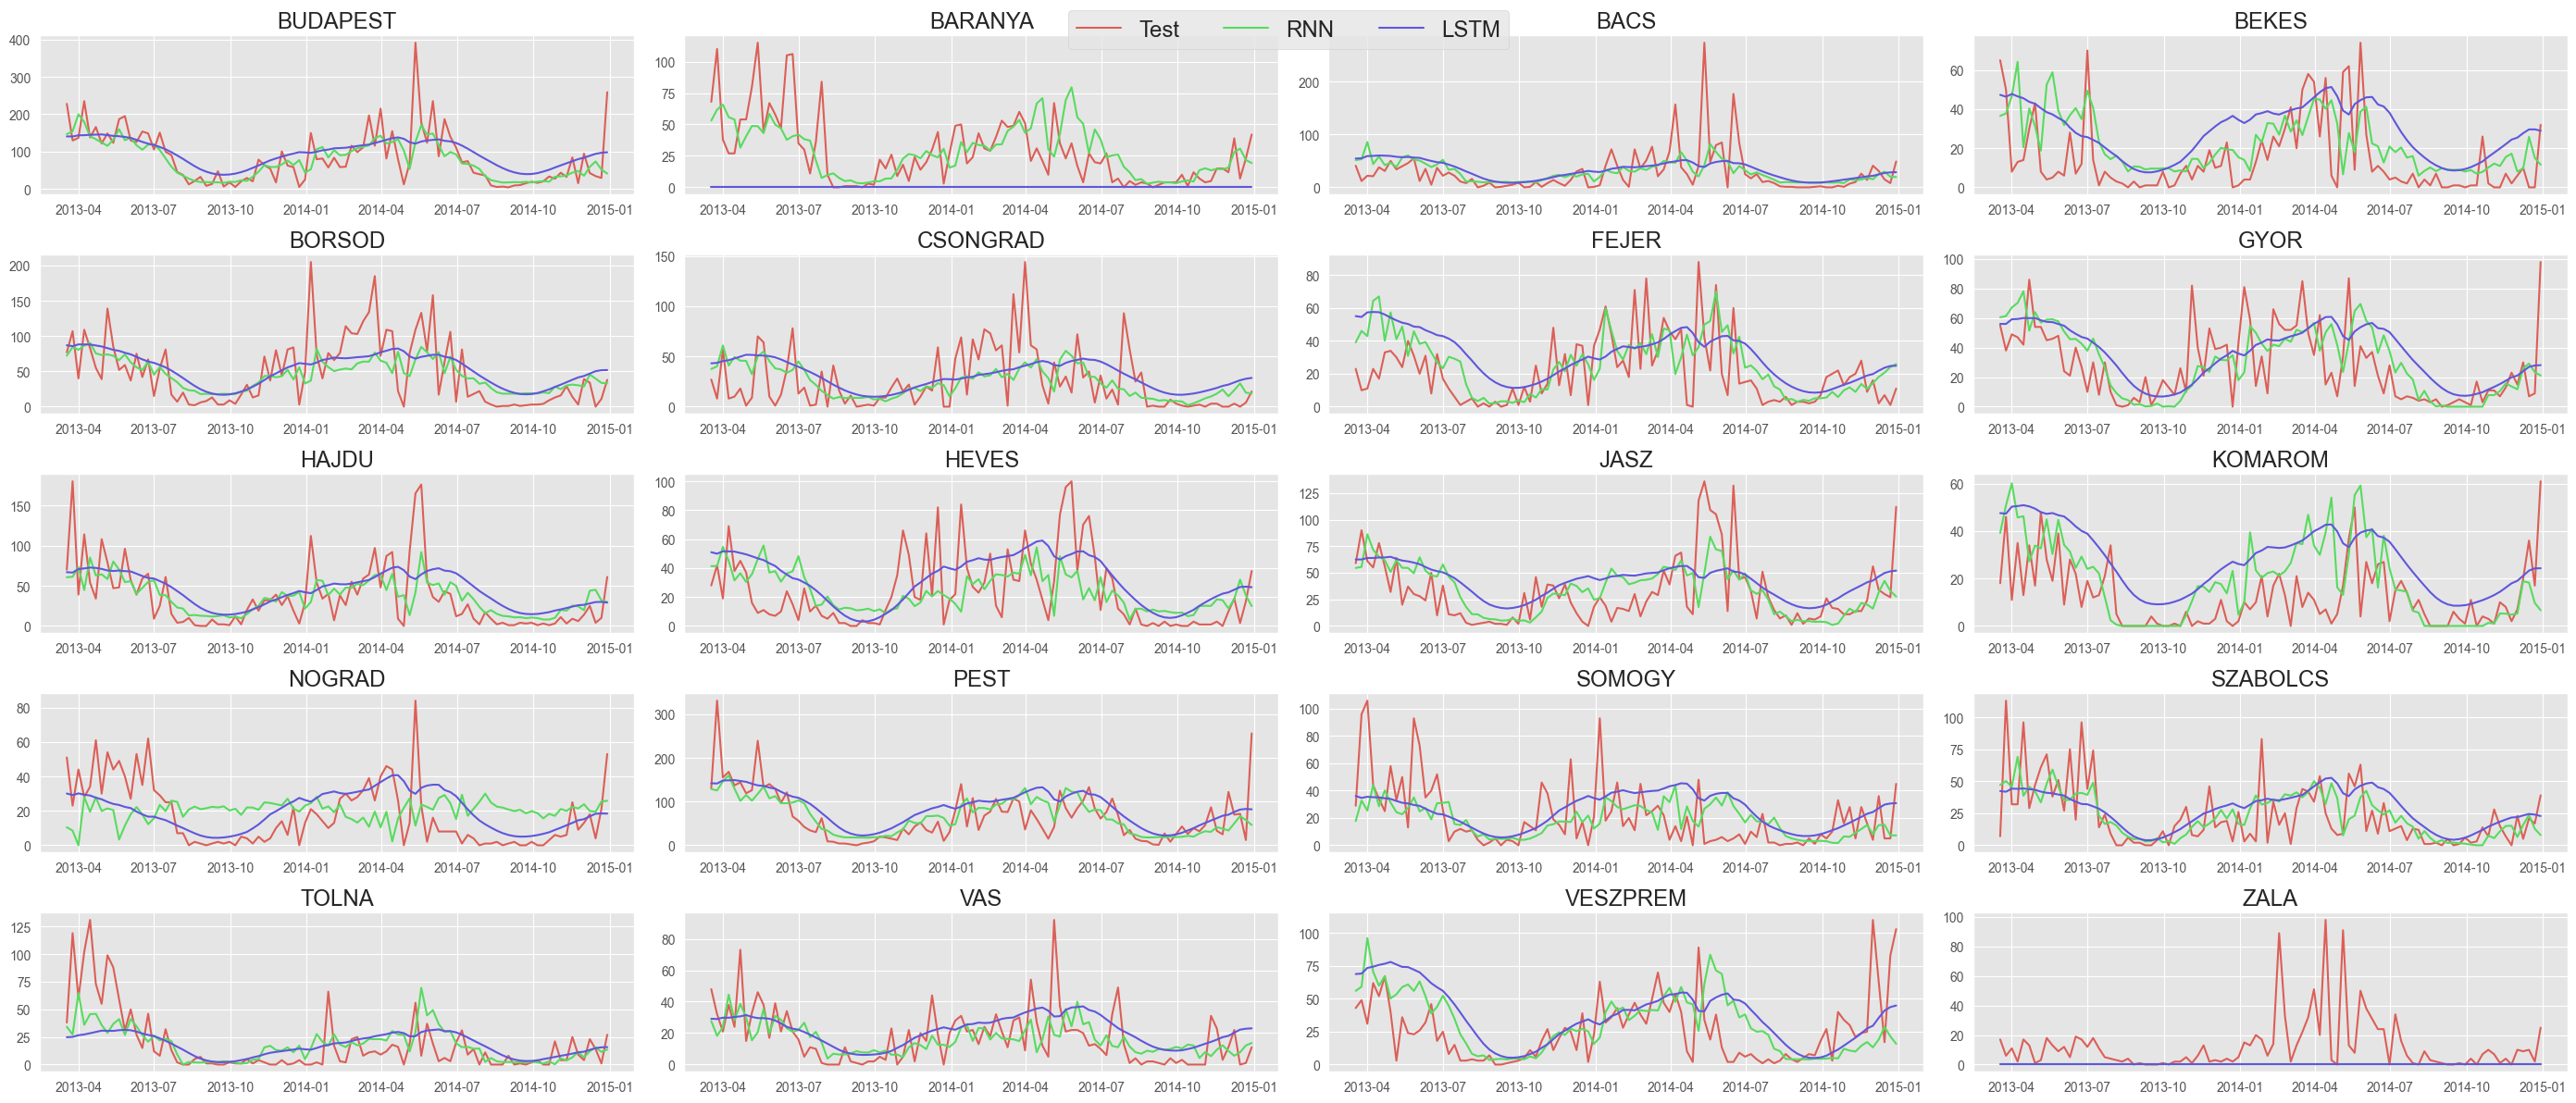

In [43]:
sns.set_palette(sns.color_palette('hls', 3))

n_rows = 5
n_columns = 4

fig, axes = plt.subplots(5, 4, tight_layout=True, figsize=(28, 12))

for i in range(20):
    ax = axes[i // n_columns, i % n_columns]
    county = data.columns[i]
    ax.set_title(county, fontsize='xx-large')
    ax.plot(df_y_test[county])
    ax.plot(df_pred_rnn[county])
    ax.plot(df_pred_lstm[county])
    
fig.legend(['Test', 'RNN', 'LSTM'], loc='upper center', ncol=3, fontsize='xx-large')
plt.show()

In [44]:
# Compute metrics
mse = (mean_squared_error(y_test, prediction_rnn_multivariate), mean_squared_error(y_test, prediction_lstm_multivariate))
rmse = (root_mean_squared_error(y_test, prediction_rnn_multivariate), root_mean_squared_error(y_test, prediction_lstm_multivariate))
mae = (mean_absolute_error(y_test, prediction_rnn_multivariate), mean_absolute_error(y_test, prediction_lstm_multivariate))

df_metrics_multivariate = pd.DataFrame(np.round([mse, rmse, mae], 5), columns=['RNN', 'LSTM'], index=['MSE', 'RMSE', 'MAE'])

In [45]:
display(df_metrics_multivariate)

,RNN,LSTM
MSE,766.41880,871.08508
RMSE,26.21443,27.80383
MAE,17.92293,20.74788
